First we load the MNIST dataset

The FIRST STEP WILL BE TO IMPLEMENT A WASSERSTEIN GAN


All the imports made are in the following box

In [0]:
import torchvision
import torchvision.datasets as datasets
import torch
import torch.nn as nn 
import random
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim



from matplotlib import pyplot as plt








In [0]:

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

tensor(0)
torch.Size([28, 28])


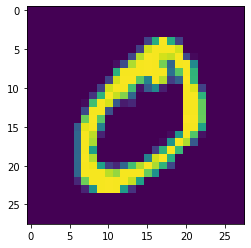

In [49]:

trainset = torchvision.datasets.MNIST(root='./DataSet', train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST(root='./DataSet', train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)


print(trainset.targets[1])

print(trainset.data[1].size())
plt.imshow(trainset.data[1])
plt.plot()


batch_size = 64

ngpu = 4
nz = 784
nc = 1 #image en nuance de gris
num_epochs=10
n_features_generator = 64
n_features_discriminator = 64

alpha = 0.00005

In [0]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    #définisssons notre générateur
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz,n_features_generator*8,3),
        nn.BatchNorm2d(n_features_generator*8),
        nn.ReLU(True),
      
        nn.ConvTranspose2d(n_features_generator*8,n_features_generator*4,3),
        nn.BatchNorm2d(n_features_generator*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(n_features_generator*4,n_features_generator*2,3) ,
        nn.BatchNorm2d(n_features_generator*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(n_features_generator*3,n_features_generator,3), #64
        nn.BatchNorm2d(n_features_generator),
        nn.Tanh()
        )   
    
    def forward(self, input):
      return self.main(input)






In [0]:
class Discriminator(nn.Module):
  def __init__(self,ngpu):
    super(Discriminator,self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(


        nn.Conv2d(nc, n_features_discriminator, 3),
        nn.ReLU(True),

        nn.Conv2d(n_features_discriminator, n_features_discriminator*2,3),
        nn.BatchNorm2d(n_features_discriminator*2),
        nn.ReLU(True),

        nn.Conv2d(n_features_discriminator*2, n_features_discriminator*4,3),
        nn.BatchNorm2d(n_features_discriminator*2),
        nn.ReLU(True),
       
        nn.Conv2d(n_features_discriminator*4, n_features_discriminator*8,3),
        nn.Sigmoid()
    )

    def forward(self, input):
      return self.main(input)

In [38]:
#creation du générateur
GenNet = Generator(ngpu).to(device)

#veillez a définir les weights
GenNet.apply(weights_init)

print(GenNet)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(784, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(192, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Tanh()
  )
)


In [43]:
#creaetion du discriminator 
DiscrimNet = Discriminator(ngpu).to(device)

DiscrimNet.apply(weights_init)
print(DiscrimNet)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): Sigmoid()
  )
)


In [0]:
#Wasserstein loss = label * average critic score

def critic_loss(y_true,y_pred):
  return mean(y_true*y_pred)



real_label = 1
fake_label=0


optimizerD = optim.Adam(DiscrimNet.parameters())
optimizerG = optim.Adam(GenNet.parameters() )


In [61]:
#On va entrainer le générateur et discriminateur


img_list = []
G_loss, D_loss = [], []
iters = 0

for epochs in range(num_epochs):
  for i , data in enumerate(trainloader):
    DiscrimNet.zero_grad()
    batch_size = data[0].to(device).size(0)
    


TypeError: ignored